In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
!unzip pickle.zip

Archive:  pickle.zip
   creating: pickle/
  inflating: pickle/.DS_Store        
  inflating: __MACOSX/pickle/._.DS_Store  
   creating: pickle/DHFR/
   creating: pickle/CRT/
   creating: pickle/DHPS/
  inflating: pickle/DHFR/trimmed_data_GB4.pkl  
  inflating: pickle/DHFR/trimmed_data_DD2.pkl  
  inflating: pickle/DHFR/trimmed_data_KH2.pkl  
  inflating: pickle/DHFR/trimmed_data_HB3.pkl  
  inflating: pickle/DHFR/trimmed_data_KH1.pkl  
  inflating: pickle/DHFR/trimmed_data_mix1.pkl  
  inflating: pickle/DHFR/trimmed_data_mix2.pkl  
  inflating: pickle/DHFR/trimmed_data_3D7.pkl  
  inflating: pickle/DHFR/trimmed_data_7G8.pkl  
  inflating: pickle/CRT/trimmed_data_DD2.pkl  
  inflating: pickle/CRT/trimmed_data_KH2.pkl  
  inflating: pickle/CRT/trimmed_data_KH1.pkl  
  inflating: pickle/CRT/trimmed_data_mix1.pkl  
  inflating: pickle/CRT/trimmed_data_mix2.pkl  
  inflating: pickle/CRT/trimmed_data_3D7.pkl  
  inflating: pickle/CRT/trimmed_data_7G8.pkl  
  inflating: pickle/DHPS/trimmed_da

In [ ]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.utils.np_utils import to_categorical
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
run_sequence = "CRT"
nb_epoch = 50
batch_size = 16
nb_filters = 48
nb_conv = 5
nb_pool = 3
nb_alignment = 2500
nb_channel = 2
nb_coverage = 100
nb_node = 128
train_loop = 4

# Sequence-specific Variables, too lazy to code the script everytime we train for a new sequence

In [ ]:
if run_sequence == "CRT":
    img_row, img_col = 101, 178
    clone_names = ["3D7","7G8","DD2"]
    nb_mutations = len(clones_names)
elif run_sequence == "DHPS":
    img_row, img_col = 101, 642
    clone_names = ["3D7","7G8","HB3"]
    nb_mutations = len(clones_names)
elif run_sequence == "DHFR":
    img_row, img_col = 101, 491
    clone_names = ["3D7","7G8","DD2","HB3"]
    nb_mutations = len(clones_names)

In [ ]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_mse', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData(file_name="clones.txt",gen_mode=2,pkl_sequence=run_sequence,pkl_clones=clone_names)
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()


Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

In [ ]:
alignments = [dg._array_dup(i,101) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here we display an image and check the error rate

[35.0, 56.00000000000001, 9.0]


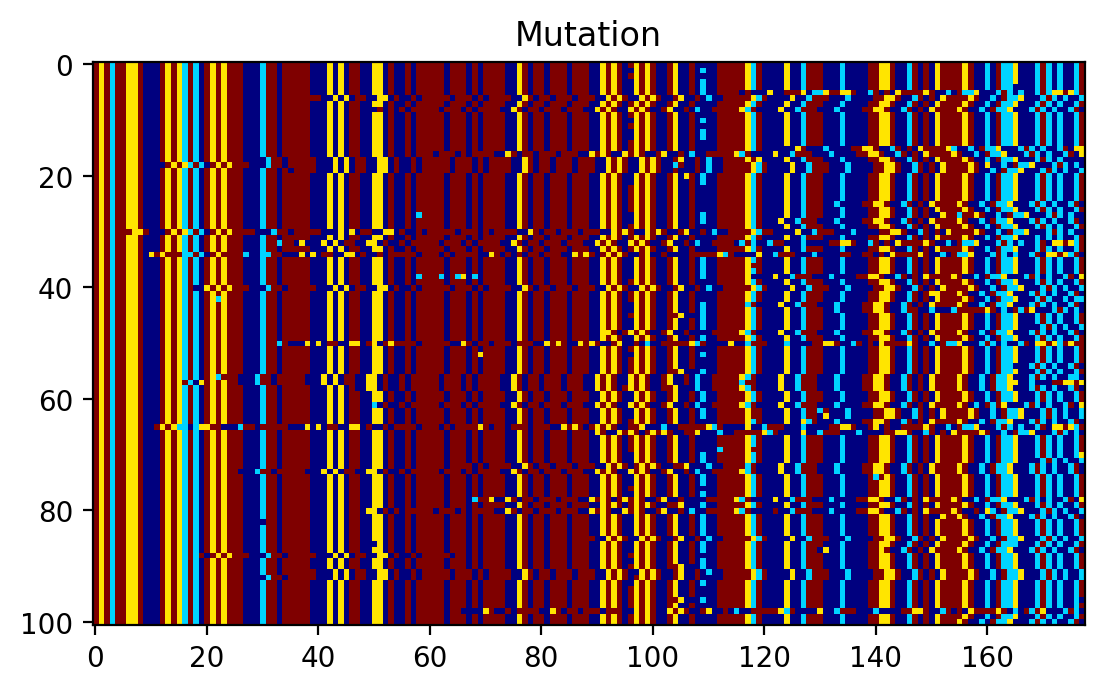

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][0],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 2, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 2, 101, 178)
(500, 2, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(nb_node))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 14s 12ms/step - loss: 109.8806 - mse: 329.7068 - val_loss: 109.9389 - val_mse: 323.4471
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 109.8698 - mse: 329.4629 - val_loss: 109.9007 - val_mse: 322.6077
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 109.8744 - mse: 329.5642 - val_loss: 109.8821 - val_mse: 322.1934
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 106.0287 - mse: 248.8353 - val_loss: 103.8438 - val_mse: 195.6965
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 103.3794 - mse: 193.5983 - val_loss: 103.1057 - val_mse: 182.3109
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 102.8958 - mse: 184.8155 - val_loss: 102.9657 - val_mse: 180.1071
Epoch 7/50
125/125 [==============================] - 1s 9ms/step - loss: 102.6769 - mse: 180.5620 - val_loss: 102.7849 - val_mse: 176.5684
Epoch 8/50
125/125

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_dup(i,101) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 11, 48)        0         
 )                                                               
                                                                 
 activation (Activation)     (None, 6, 11, 48)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 48)          0

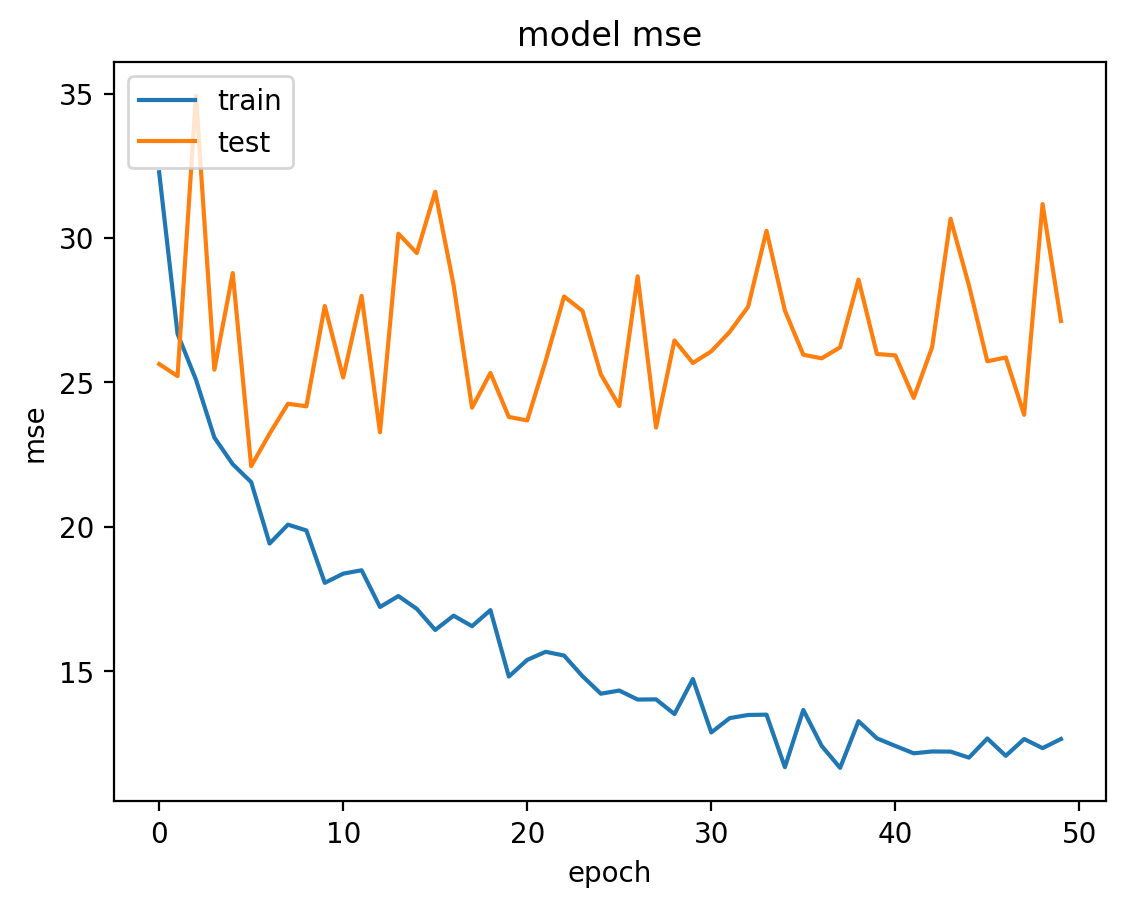

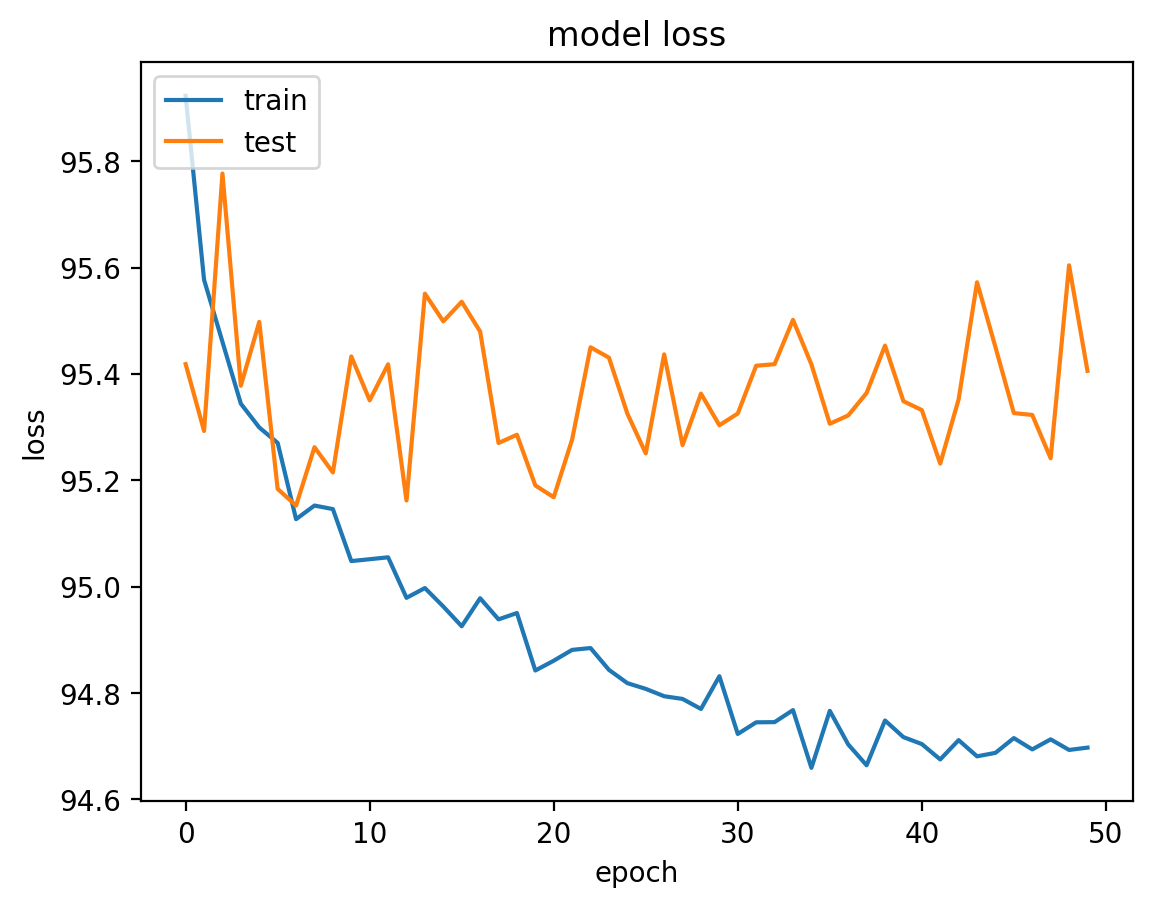

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('ref.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 8ms/step


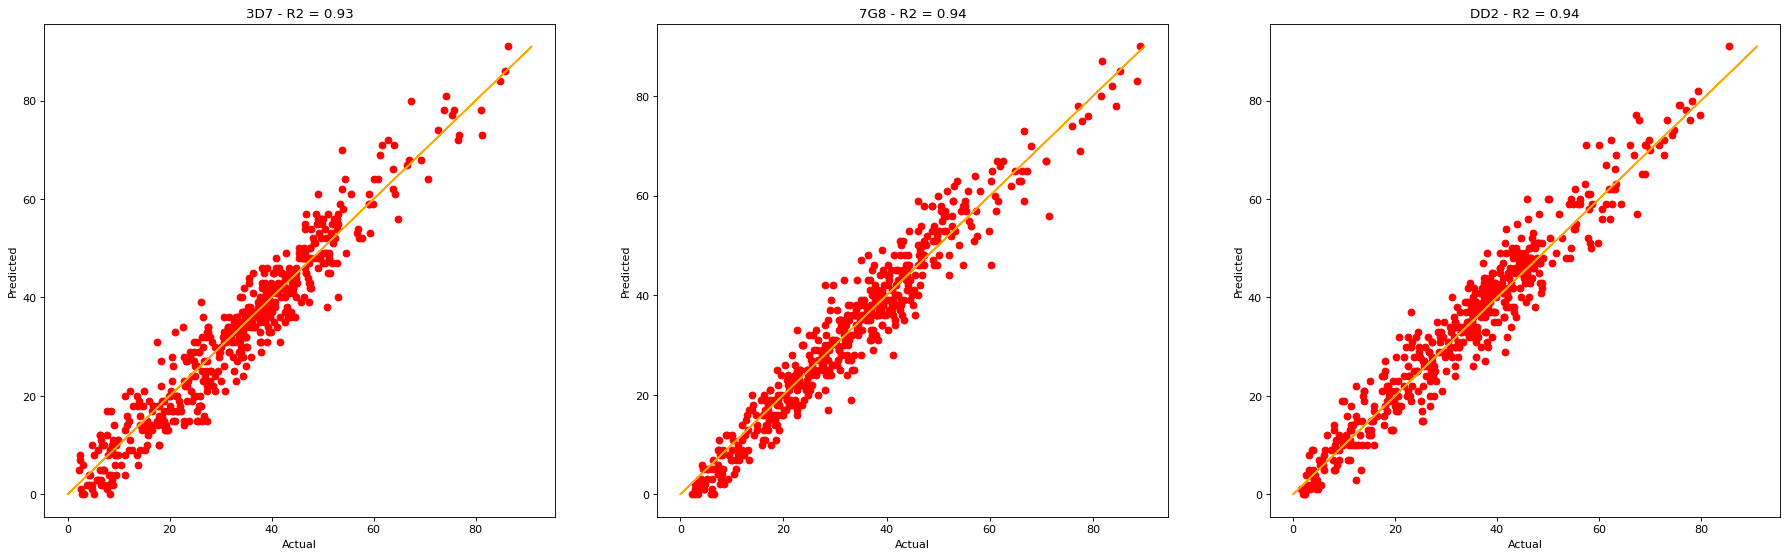

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict = pd.DataFrame(predict_array)
df_actual = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict.columns = clone_names
df_actual.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual[clone_names[i]], df_predict[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual[clone_names[i]], df_predict[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual[clone_names[i]])
    plt.plot(df_actual[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red')

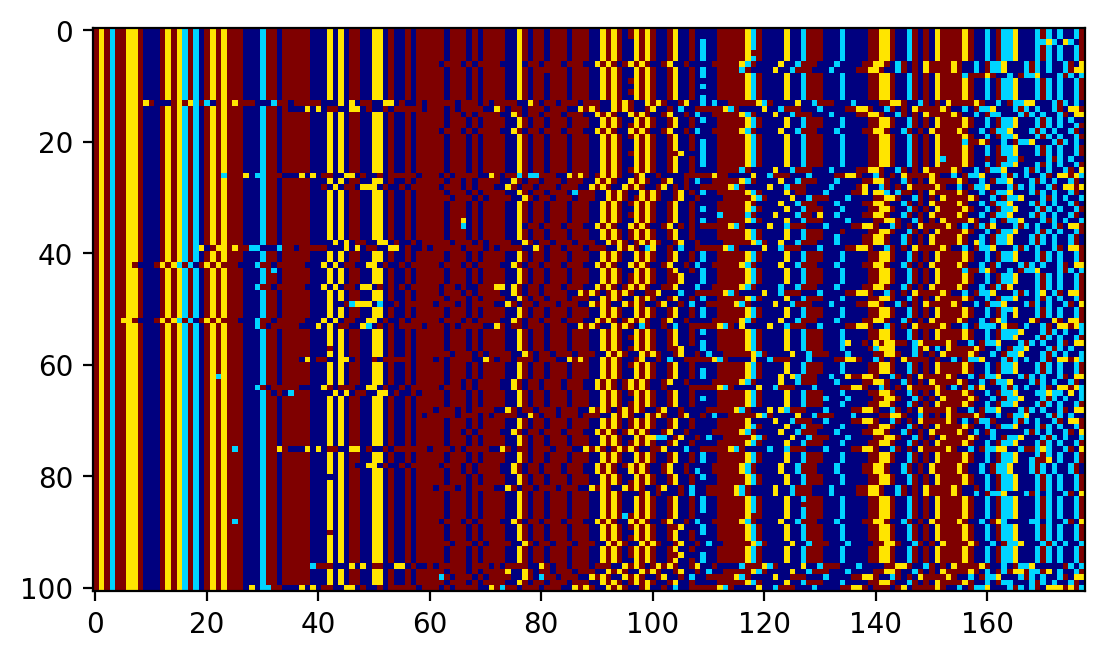

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.imshow(valid_alignments[0].reshape(nb_channel,img_row,img_col)[0],cmap='jet')

# Here we run the same training regime but replacing the second channel with a binary map

In [ ]:
alignments = [dg._array_binary_mask(i,101) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Display the binary map

[63.0, 16.0, 21.0]


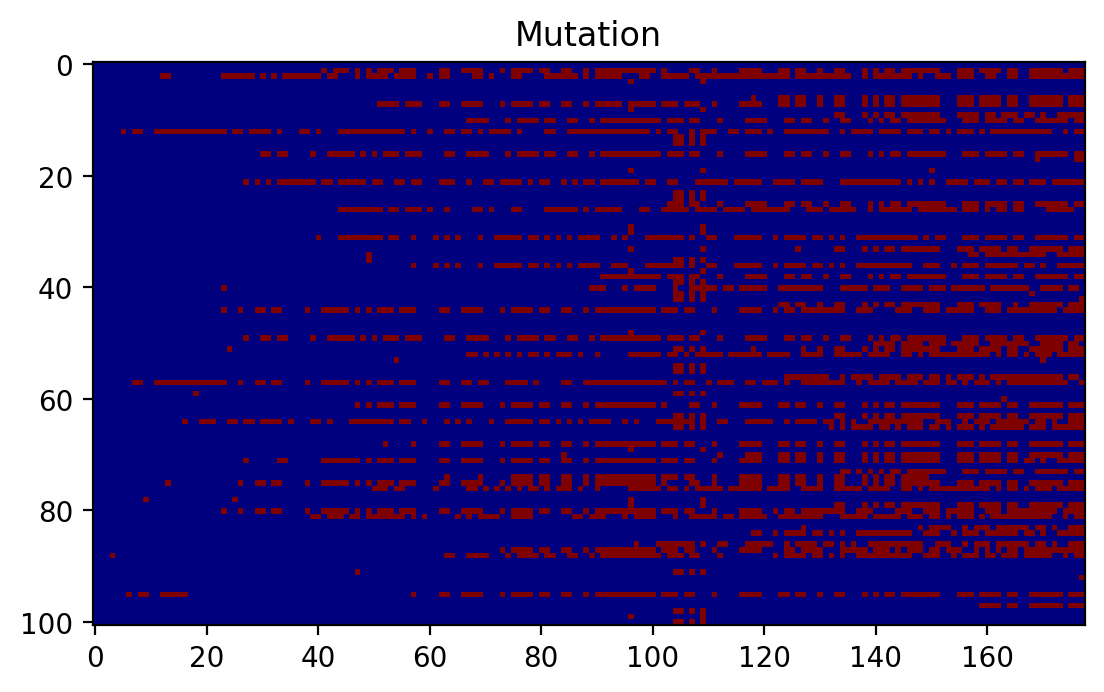

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 2, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 2, 101, 178)
(500, 2, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 4s 10ms/step - loss: 109.8817 - mse: 317.3437 - val_loss: 109.9048 - val_mse: 321.9682
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 108.2061 - mse: 280.9311 - val_loss: 104.4703 - val_mse: 206.5728
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 104.2006 - mse: 200.7445 - val_loss: 103.3128 - val_mse: 185.3904
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 103.1700 - mse: 179.4560 - val_loss: 103.1074 - val_mse: 180.5365
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 102.8957 - mse: 175.1141 - val_loss: 102.8689 - val_mse: 175.7446
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 102.7723 - mse: 172.3844 - val_loss: 102.9958 - val_mse: 178.8070
Epoch 7/50
125/125 [==============================] - 1s 9ms/step - loss: 102.6492 - mse: 170.1547 - val_loss: 102.9781 - val_mse: 178.4407
Epoch 8/50
125/125 

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_binary_mask(i,101) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 11, 48)        0         
 2D)                                                             
                                                                 
 activation_6 (Activation)   (None, 6, 11, 48)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)         

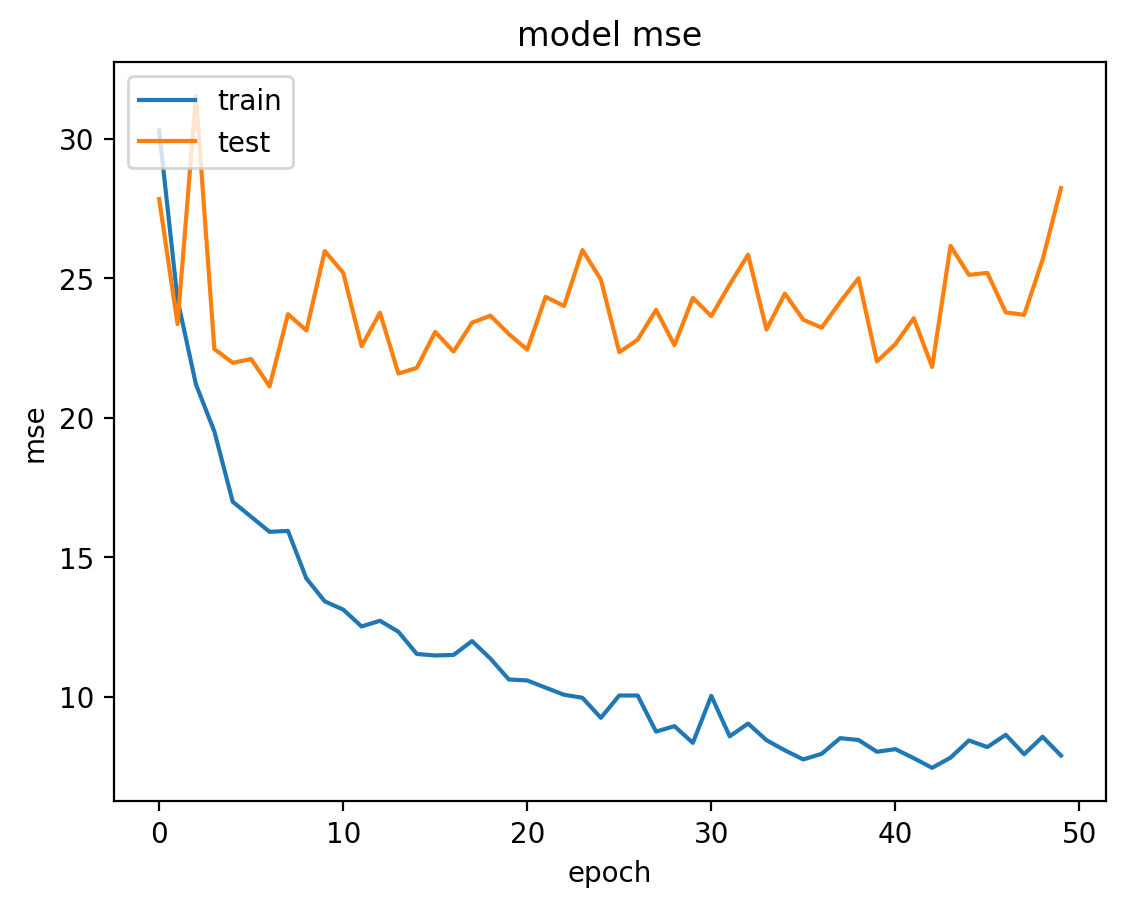

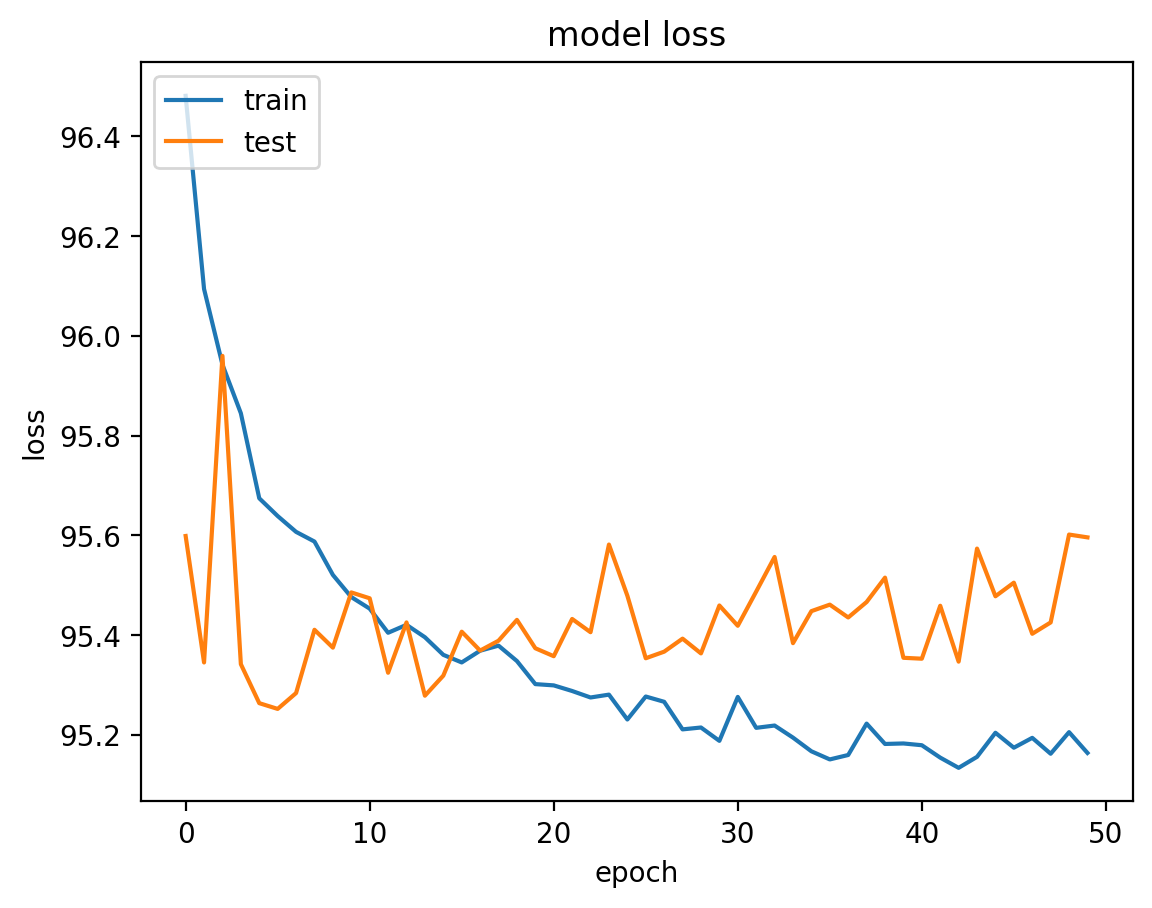

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bin_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 3ms/step


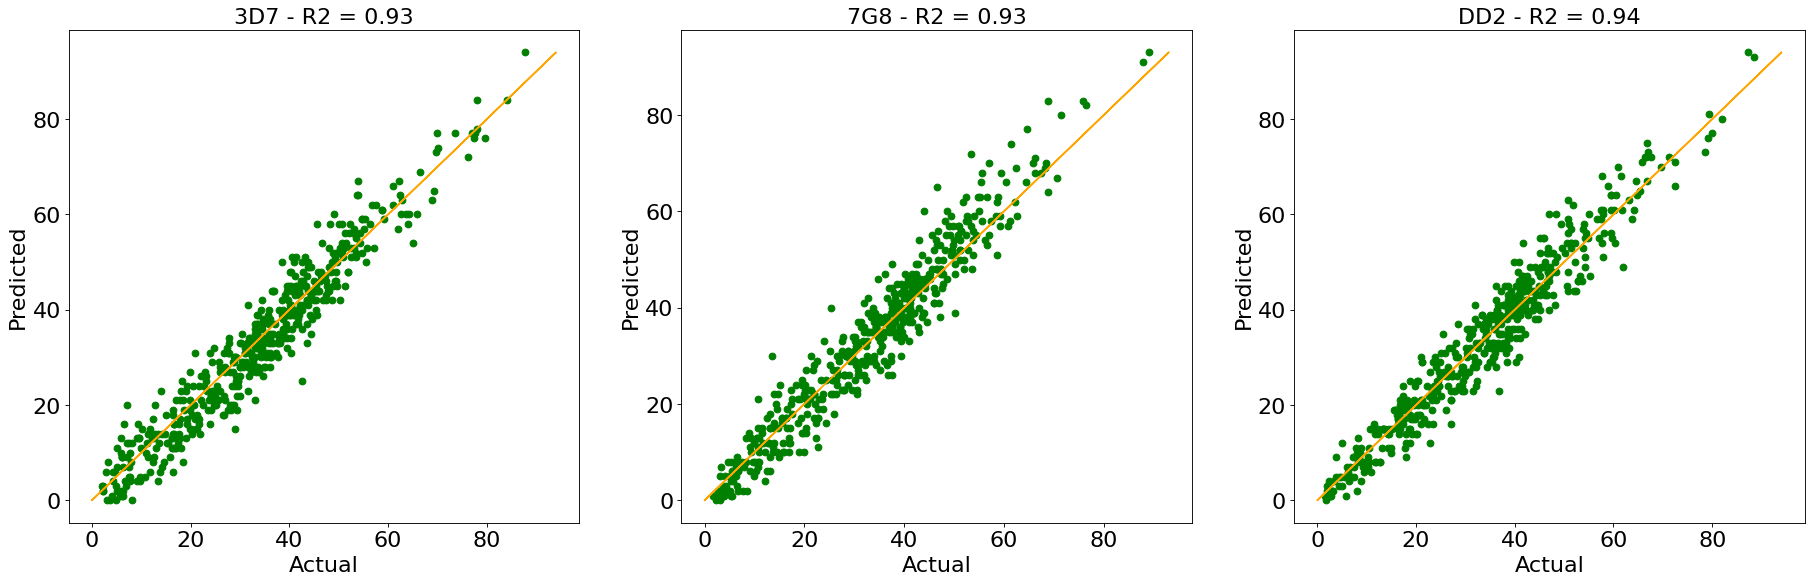

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_binary_map = pd.DataFrame(predict_array)
df_actual_binary_map = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_binary_map.columns = clone_names
df_actual_binary_map.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)),fontsize=20)
    plt.ylabel('Predicted',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Actual',fontsize=20)
    plt.xticks(fontsize=20)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]],color='green')

# Here we run with both binary map and referecen matrix

In [ ]:
alignments = [dg._array_binary_mask(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here the number of channel will be updated to 3
nb_channel = 3

[45.0, 28.999999999999996, 26.0]


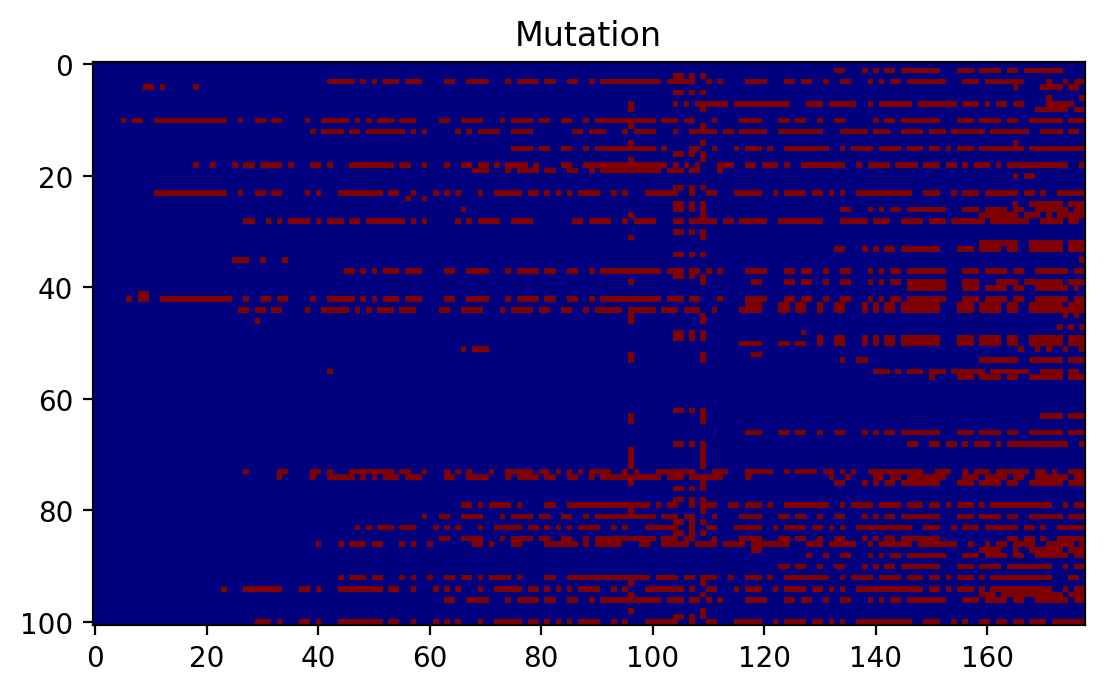

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 3, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 3, 101, 178)
(500, 3, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 4s 10ms/step - loss: 109.8600 - mse: 306.2292 - val_loss: 109.8678 - val_mse: 318.3423
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 108.1089 - mse: 267.8248 - val_loss: 103.9115 - val_mse: 187.9427
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 103.5989 - mse: 170.9394 - val_loss: 101.2513 - val_mse: 131.6389
Epoch 4/50
125/125 [==============================] - 1s 10ms/step - loss: 99.4638 - mse: 84.2231 - val_loss: 97.1714 - val_mse: 52.6183
Epoch 5/50
125/125 [==============================] - 1s 9ms/step - loss: 97.9791 - mse: 55.5649 - val_loss: 96.4768 - val_mse: 41.5293
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 96.8963 - mse: 37.3620 - val_loss: 96.2211 - val_mse: 36.0653
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 96.7216 - mse: 34.2037 - val_loss: 96.4122 - val_mse: 40.2978
Epoch 8/50
125/125 [==============

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_binary_mask(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 20, 35, 48)        3648      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 11, 48)        0         
 2D)                                                             
                                                                 
 activation_12 (Activation)  (None, 6, 11, 48)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 48)         

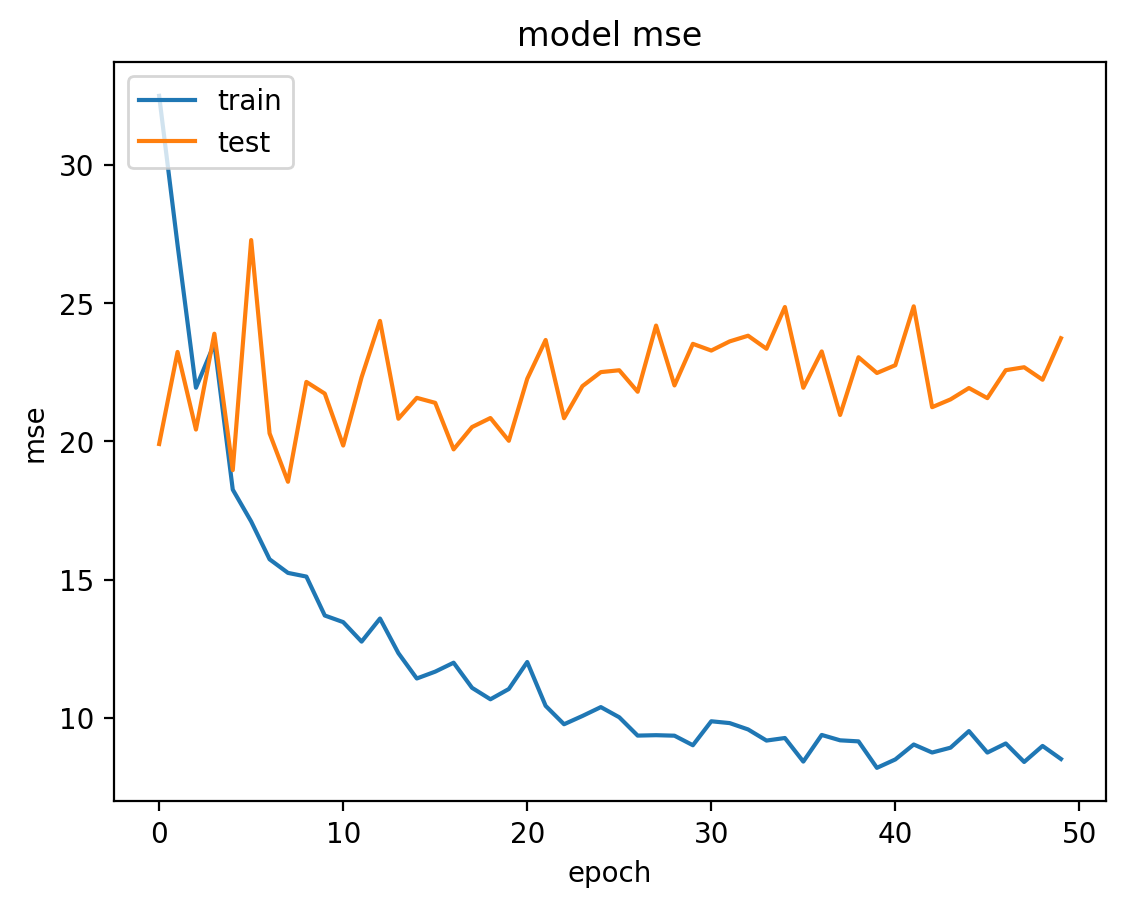

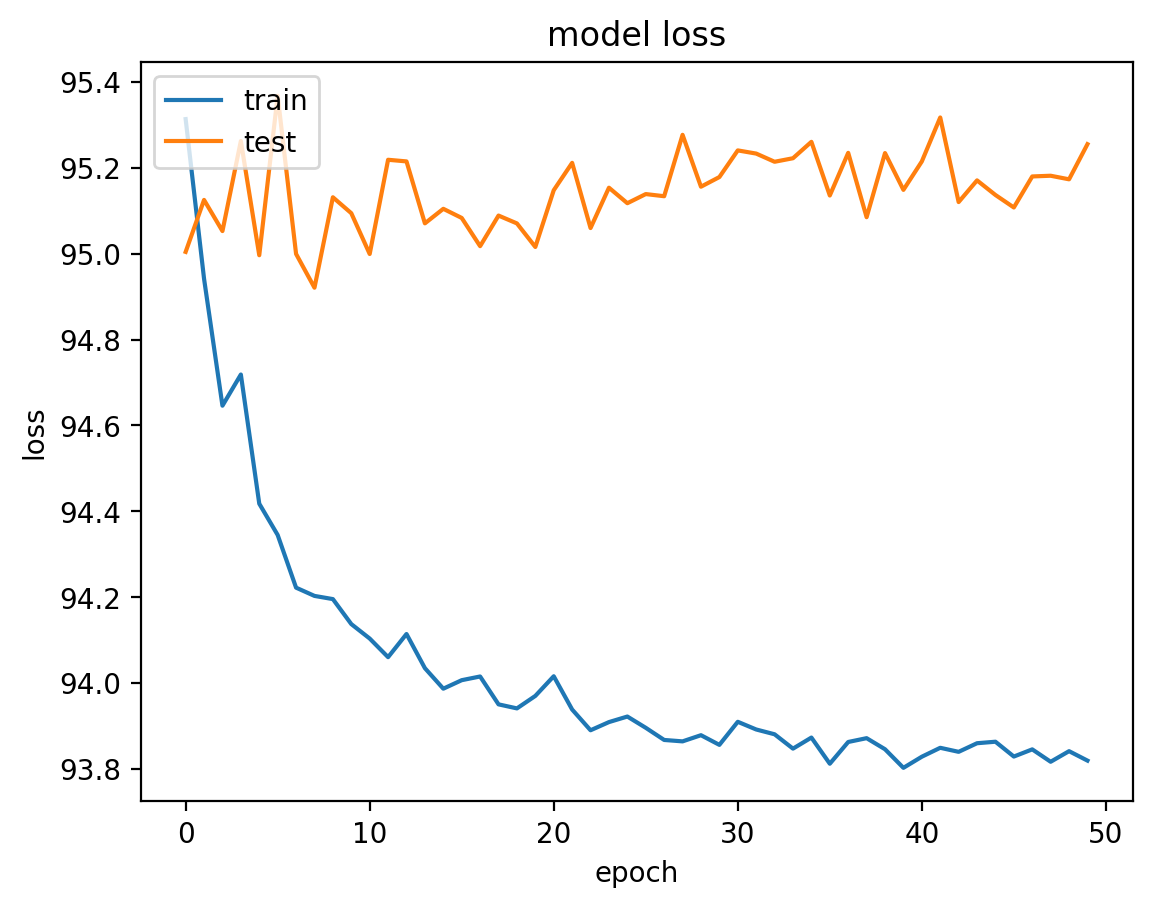

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bin_ref_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 7ms/step


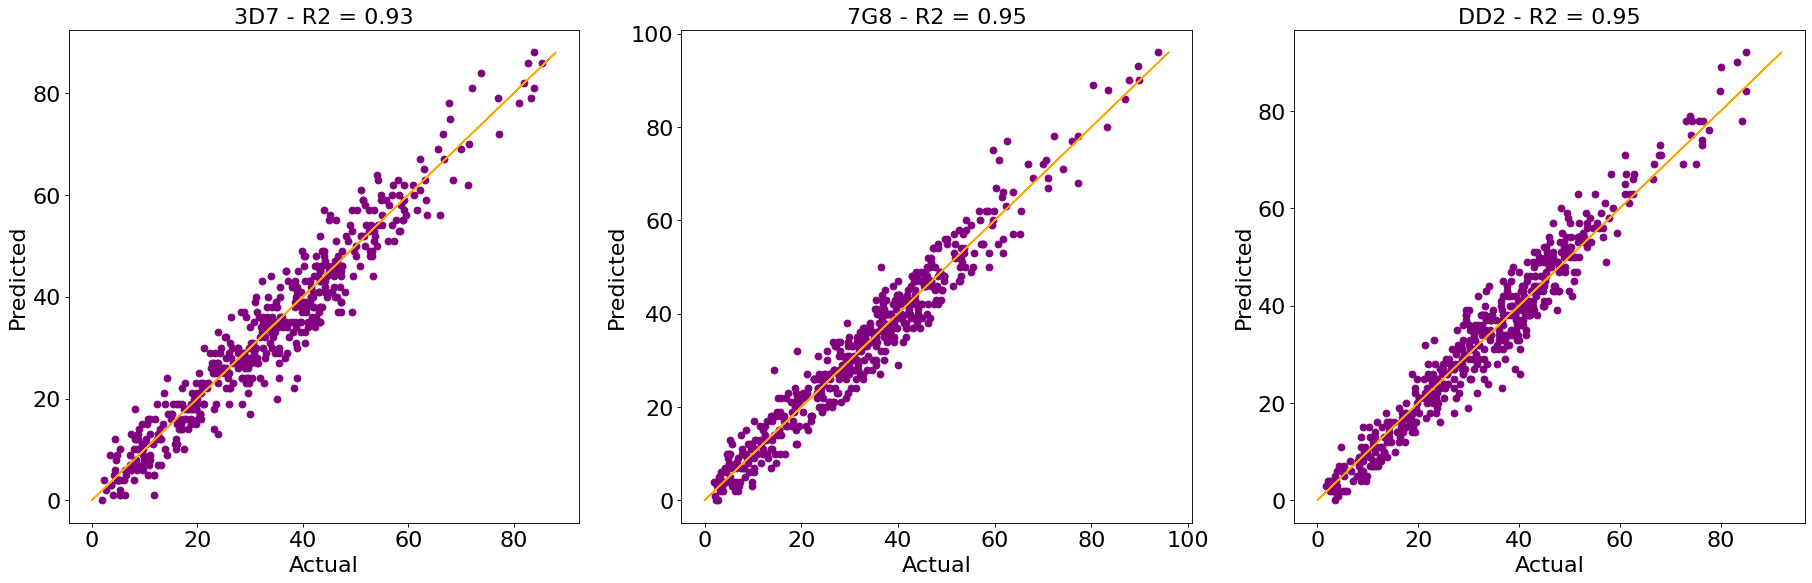

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_both = pd.DataFrame(predict_array)
df_actual_both = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_both.columns = clone_names
df_actual_both.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_both[clone_names[i]])
    plt.plot(df_actual_both[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)),fontsize=20)
    plt.ylabel('Predicted',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Actual',fontsize=20)
    plt.xticks(fontsize=20)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='purple')

# Here we analyse the results and compare the MSE

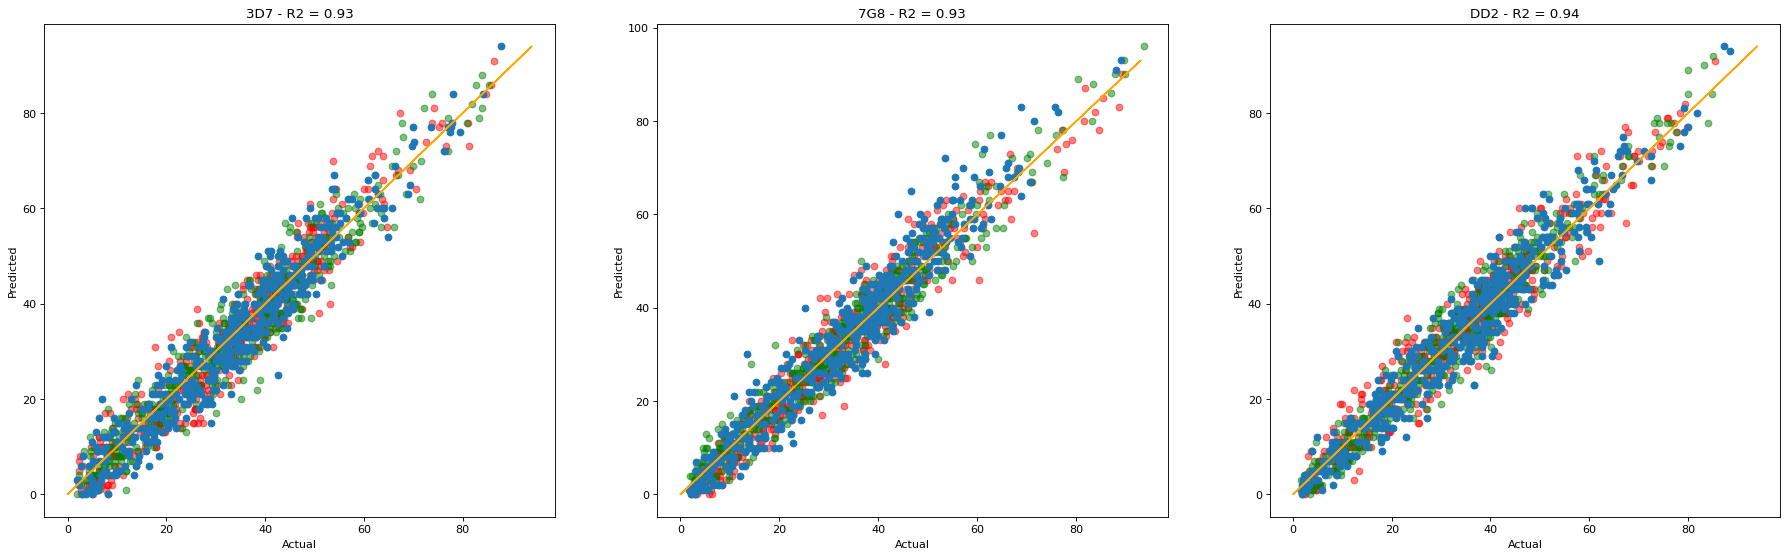

In [ ]:
plt.figure(figsize=(28, 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red',alpha=0.5)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='green',alpha=0.5)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]])

# Here we try separating into base-pair maps

In [ ]:
alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here the number of channel will be updated to 3
nb_channel = 5

[40.0, 10.0, 50.0]


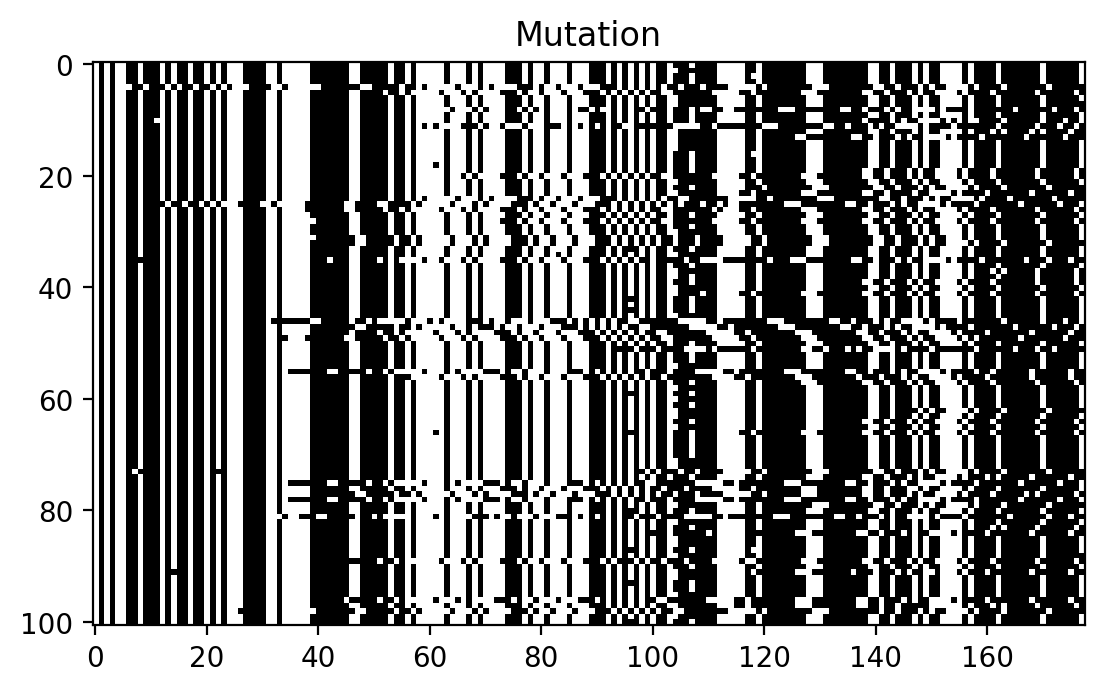

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1], cmap='Greys_r')
#test_array = np.zeros((178, 100))
#plt.imshow(test_array, cmap='Greys')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 5, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 5, 101, 178)
(500, 5, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 5s 17ms/step - loss: 109.8922 - mse: 333.6747 - val_loss: 109.8565 - val_mse: 328.5501
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 108.3441 - mse: 299.4202 - val_loss: 103.9606 - val_mse: 198.6189
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 103.4384 - mse: 192.0080 - val_loss: 102.8284 - val_mse: 173.3648
Epoch 4/50
125/125 [==============================] - 1s 9ms/step - loss: 102.7433 - mse: 177.5210 - val_loss: 102.1372 - val_mse: 159.1375
Epoch 5/50
125/125 [==============================] - 1s 8ms/step - loss: 99.9211 - mse: 118.1023 - val_loss: 96.8500 - val_mse: 50.6497
Epoch 6/50
125/125 [==============================] - 1s 8ms/step - loss: 96.7267 - mse: 57.1858 - val_loss: 96.4897 - val_mse: 45.8549
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 96.0140 - mse: 44.8242 - val_loss: 95.9238 - val_mse: 35.0728
Epoch 8/50
125/125 [==========

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bp_map_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_bp_channel = pd.DataFrame(predict_array)
df_actual_bp_channel = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_bp_channel.columns = clone_names
df_actual_bp_channel.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_bp_channel[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict_bp_channel[clone_names[i]], df_actual_bp_channel[clone_names[i]])

In [93]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

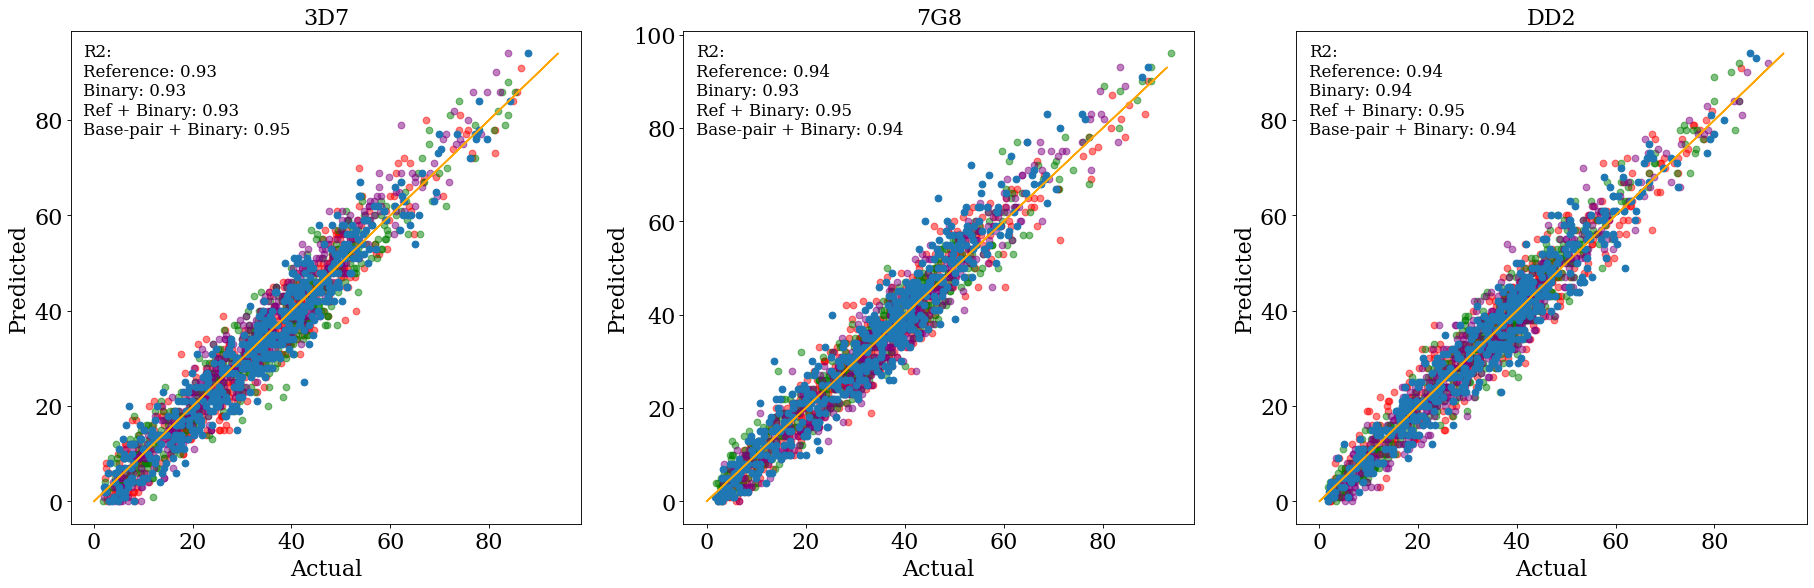

In [94]:
hfont = {'fontname':'serif'}

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2_ref = r2_score(df_actual[clone_names[i]], df_predict[clone_names[i]])
    r2_bin = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    r2_ref_bin = r2_score(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]])
    r2_bp_bin = r2_score(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name}'.format(seq_name=clone_names[i]),fontsize=20,**hfont)
    plt.text(0.025, 0.975, 'R2:\nReference: {r2_ref_score}\nBinary: {r2_bin_score}\nRef + Binary: {r2_ref_bin_score}\nBase-pair + Binary: {r2_bp_bin_score}'.format(r2_ref_score=round(r2_ref,2),r2_bin_score=round(r2_bin,2),r2_ref_bin_score=round(r2_ref_bin,2),r2_bp_bin_score=round(r2_bp_bin,2)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=plt.gca().transAxes,fontsize=15,**hfont)
    plt.ylabel('Predicted',fontsize=20,**hfont)
    plt.yticks(fontsize=20,**hfont)
    plt.xlabel('Actual',fontsize=20,**hfont)
    plt.xticks(fontsize=20,**hfont)
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red',alpha=0.5)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='green',alpha=0.5)
    plt.scatter(df_predict_bp_channel[clone_names[i]], df_actual_bp_channel[clone_names[i]],color='purple',alpha=0.5)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]])


In [95]:
ax = 0

mse = []
mse_binary_map = []
mse_both = []
mse_bp_channel = []

for i in range(0,len(clone_names)):
    mse.append(((df_predict[clone_names[i]] - df_actual[clone_names[i]])**2).mean(axis=ax))
    mse_binary_map.append(((df_predict_binary_map[clone_names[i]] - df_actual_binary_map[clone_names[i]])**2).mean(axis=ax))
    mse_both.append(((df_predict_both[clone_names[i]] - df_actual_both[clone_names[i]])**2).mean(axis=ax))
    mse_bp_channel.append(((df_predict_bp_channel[clone_names[i]] - df_actual_bp_channel[clone_names[i]])**2).mean(axis=ax))

In [96]:
for i in range(0,len(clone_names)):
    print_string = str(mse[i]) + "\t" + str(mse_binary_map[i]) + "\t" + str(mse_both[i]) + "\t" + str(mse_bp_channel[i])
    print(print_string)

23.09526634667359	21.862864787691223	21.82627707056248	18.70712459332498
19.551528281316802	23.695410412526446	16.303516209062135	19.044318193869817
20.029043995804116	18.8433594297187	17.480579747265793	19.215436315582426


In [97]:
print(valid_prob_lists[1])
print(df_predict.iloc[1])
print(df_predict_binary_map.iloc[1])
print(df_predict_both.iloc[1])
print(df_predict_bp_channel.iloc[1])

[56. 11. 33.]
3D7    28.472849
7G8    48.818310
DD2    22.708843
Name: 1, dtype: float64
3D7    45.515816
7G8    50.137115
DD2     4.347064
Name: 1, dtype: float64
3D7    38.207916
7G8    26.875294
DD2    34.916790
Name: 1, dtype: float64
3D7    60.688358
7G8     6.229396
DD2    33.082245
Name: 1, dtype: float64
